# MAE and MSE optimal weights

This notebook contains the theoretical plots of the optimal weight based on MSE and MAE using a Skew normal distribution reproducing Figure 1: MAE and MSE optimal weights in the paper. The plot is constructed using [Julia](https://julialang.org/) v1.6.2 with the following models 

- [Plots](https://docs.juliaplots.org/latest/) v1.20.0
- [QuadGK](https://juliapackages.com/p/quadgk) v2.4.1
- [Distributions](https://juliastats.org/Distributions.jl/stable/) v0.24.18

In [1]:
using Plots
using QuadGK, Distributions

## Background

The plots aims to show $\mathbb{E} \left [ z^2(\pmb{\alpha}) \right ]$ and $\mathbb{E} \left [ |z(\pmb{\alpha})| \right ]$ where $\pmb{\alpha} = \left ( \alpha_1, \alpha_2 \right )'$ and 

$$
    z = \alpha_1 y_1 + \alpha_2 y_2
$$ 

with both $y_1$ and $y_2$ follow independent skewed normal distribution as defined in Azzalini (1985). The first graph imposes the *affine* restriction that $\alpha_1 + \alpha_2 = 1$ whereas the second graph imposes a different linear restriction such that $\alpha_1 + \alpha_2 = 0.5$. 

In both cases, the computation utilises the fact that the skewed normal distribution has the following stochastic representation 

$$ y_i = \xi_i + \lambda_i |\tau_i| + u_i $$

where $\tau_i$ and $u_i$ are two independent normal random variates with $\tau_i \sim N(0,1)$ and $u_i \sim N(0, \sigma^2_i)$. 

Under these settings, straightforward algebra yields

$$
\begin{align}
\mathbb{E} \left [ z^2(\pmb{\alpha}) \right ] =& \delta ^2 (1-2\pi) + \alpha_1^2\sigma^2_1 + \alpha_2^2\sigma^2_2\\
\mathbb{E} \left [ |z(\pmb{\alpha})| \right ] =& \int^\infty_{-\infty} |z| f(z) dz
\end{align}
$$

where $\delta = \alpha_1\lambda_1 + \alpha_2 \lambda_2$ and 

$$ f(z) = 2 \phi \left (z \bigg | -\delta \sqrt{\frac{2}{\pi}}, \alpha_1\sigma^2_1 + \alpha_2 \sigma^2_2 \right ) \Phi \left [ \frac{ \delta (z+\delta \sqrt{2/\pi} )}{\alpha^2_1 \sigma^2_1 + \alpha^2_2 \sigma^2_2}  \bigg | 1- \frac{\lambda_1\lambda_2}{\alpha^2_1 \sigma^2_1 + \alpha^2_2\sigma^2_2} \right ]
$$

where $\phi(x|\mu, \sigma^2)$ and $\Phi(x| \mu, \sigma^2)$ denote the PDF and CDF of a normal distribution with mean $\mu$ and variance $\sigma^2$, respectively. 

The Julia code that implements the above can be found in [MAECode.jl](https://gitlab.com/chansta/mae-forecast/-/blob/master/code/julia/MAECode.jl) which can be donwloaded [here](https://gitlab.com/chansta/mae-forecast/-/blob/master/code/julia/MAECode.jl). 


#### SKEW NORMAL FUNCTION FOR MSE

In [2]:
"""
## Usage
skewNormalMSE(a::Float64, lambda::Array{Float64,1}, sigma::Array{Float64,1})::Float64

## Description:

Calcualte the expected value of z = alpha y_1 + (1-alpha) y_2 when y_i follows a skewed normal distribution. 

The skewed normal distribution is presumed to the following stochastic representationn 

y_i = xi_i + lambda_i tau_i + u_i

where tau_i and u_i follow a half normal and a normal respectively. 

## Input:
    a: 

"""
function skewNormalMSE(a::Float64, lambda::Array{Float64,1}, sigma::Array{Float64,1})::Float64
    delta = a*lambda[1] + (1-a)*lambda[2]
    tsigma = a^2*sigma[1] + (1-a)^2*sigma[2]
    return delta^2*(1-2/pi) + tsigma
end

skewNormalMSE

#### SKEW NORMAL FUNCTIONS FOR MAE

In [3]:
"""
Calculate the expected value of |z| where z = alpha y_1 + (1-alpha) y_2 with y_i following a skewed normal distribution. 

Input:

"""

function skewNormalMAE(a::Array{Float64,1}, lambda::Array{Float64,1}, sigma::Array{Float64,1})::Array{Float64}
    temp(s) = SkewNormalExpectedAbsolute(s, lambda, sigma)
    return temp.(a)
end

function SkewNormalExpectedAbsolute(a::Float64, lambda::Array{Float64,1}, sigma::Array{Float64,1})::Float64
    delta = a*lambda[1] + (1-a)*lambda[2]
    tsigma = a^2*sigma[1] + (1-a)^2*sigma[2]
    densityform = Distributions.Normal(-delta*(2/pi)^(0.5), tsigma)
    cdfform = Distributions.Normal(0, 1-(delta^2)/tsigma)
    density(x) = abs(x)*Distributions.pdf(densityform, x)*Distributions.cdf(cdfform, (x+delta*(2/pi)^(0.5))*delta/tsigma)
    integrate = quadgk(density, -Inf, Inf)
    return integrate[1]
end

SkewNormalExpectedAbsolute (generic function with 1 method)

## Figure 1 (b): Weights sum to 0.5

In this setting, the restriction has changed to $\alpha_1 + \alpha_2 = 0.5$. Otherwise, all other settings remain the same. This plot leverages the more general dispatch of *skewNormalMSE* and *skewNormalMAE* where the first argument is an array that contains both values of $\alpha_1$ and $\alpha_2$. The restriction, $\alpha_1+\alpha_2=0.5$ is imposed by constructing the following array. 



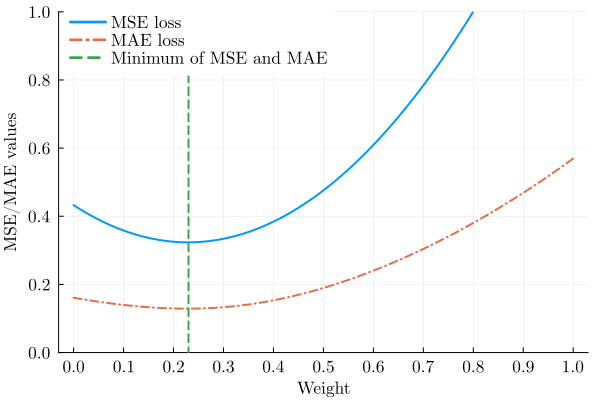

In [4]:
arange = collect(range(0,stop=1,step=0.01))
lambda = [0.4, -0.3]
sigma = [1.5; 0.4]
fixedSN(a) = skewNormalMSE(a, lambda, sigma)
MSEy = fixedSN.(arange)
MAEy = skewNormalMAE(arange, lambda, sigma)
incr = 0
lb,up =1,size(arange)[1]
plot(arange[lb:up], MSEy[lb:up],labels="MSE loss", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=(0.1, 0.97),fg_legend = :transparent, ylims=(0,1),linewidth = [2 1 1],legendfont = font("Computer Modern",11))
plot!(arange[lb:up], MAEy[lb:up].+incr,labels="MAE loss",style=:dashdot,linewidth = [2 1 1])
figure1 = vline!([arange[argmin(MSEy)]], labels="Minimum of MSE and MAE", style=:dash,linewidth = [2 1 1])
xticks!(range(0,stop=1,step=0.1))
xaxis!("Weight", font("Computer Modern",11))
yaxis!("MSE/MAE values", font("Computer Modern",11))

In [ ]:
savefig(figure1, "figure1.pdf")

#### Optimal weight location

In [5]:
argmin(MSEy), argmin(MAEy)

(24, 24)

#### Optimal weight value

In [6]:
arange[24]

0.23

### Figure 2 (b): Weights sum to 0.5

In [7]:
aset = collect(range(0,stop=1,step=0.01))
bset = 0.5 .- aset
weight = [aset bset]

101×2 Matrix{Float64}:
 0.0    0.5
 0.01   0.49
 0.02   0.48
 0.03   0.47
 0.04   0.46
 0.05   0.45
 0.06   0.44
 0.07   0.43
 0.08   0.42
 0.09   0.41
 0.1    0.4
 0.11   0.39
 0.12   0.38
 ⋮     
 0.89  -0.39
 0.9   -0.4
 0.91  -0.41
 0.92  -0.42
 0.93  -0.43
 0.94  -0.44
 0.95  -0.45
 0.96  -0.46
 0.97  -0.47
 0.98  -0.48
 0.99  -0.49
 1.0   -0.5

#### Redifining the functions (for description see above)

In [8]:
function skewNormalMSE(a::Array{Float64,1}, lambda::Array{Float64,1}, sigma::Array{Float64,1})::Float64
    delta = transpose(a)*lambda
    tsigma = transpose(a.^2)*sigma
    return delta^2*(1-2/pi) + tsigma
end

function skewNormalMAE(a::Array{Float64,2}, lambda::Array{Float64,1}, sigma::Array{Float64,1})::Array{Float64}
    temp(s) = SkewNormalExpectedAbsolute(s, lambda, sigma)
    return [temp(convert(Array{Float64,1},sa)) for sa in eachrow(a)]
end

function SkewNormalExpectedAbsolute(a::Array{Float64,1}, lambda::Array{Float64,1}, sigma::Array{Float64,1})::Float64
    delta = transpose(a)*lambda
    tsigma = transpose(a.^2)*sigma
    densityform = Distributions.Normal(-delta*(2/pi)^(0.5), tsigma)
    cdfform = Distributions.Normal(0, 1-(delta^2)/tsigma)
    density(x) = abs(x)*Distributions.pdf(densityform, x)*Distributions.cdf(cdfform, (x+delta*(2/pi)^(0.5))*delta/tsigma)
    integrate = quadgk(density, -Inf, Inf)
    return integrate[1]
end

SkewNormalExpectedAbsolute (generic function with 2 methods)

In [9]:
#MSE_nocont = [skewNormalMSE(weight[i,:], lambda, sigma) for i in range(1, stop=size(weight)[1])]
MSE_nocont = [skewNormalMSE(convert(Array{Float64,1},w), lambda, sigma) for w in eachrow(weight)]
MAE_nocont = skewNormalMAE(weight, lambda, sigma)

101-element Vector{Float64}:
 0.059639947949441455
 0.057341192198405035
 0.05507971741308109
 0.05286210268179257
 0.05069744663160191
 0.04859761476186998
 0.046577415107910546
 0.04465465194946257
 0.042849997174000266
 0.04118661761028749
 0.03968951099038692
 0.03838453802353512
 0.037297192278623915
 ⋮
 0.4590901999067594
 0.4694339442683118
 0.4799077822141088
 0.4905121206871206
 0.5012473600825603
 0.5121138945041035
 0.5231121107463651
 0.5342423904696766
 0.545505108123353
 0.5569006320610035
 0.5684293243815686
 0.5800915409847238

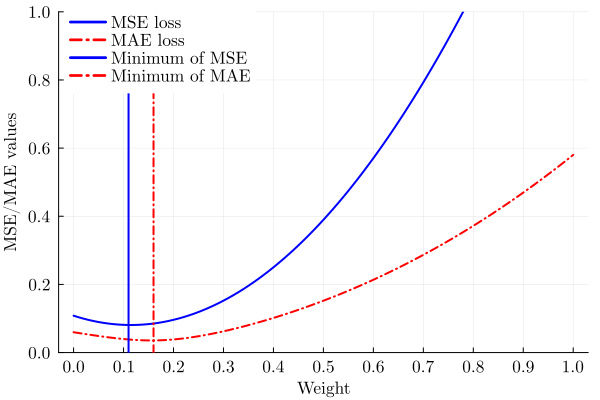

In [10]:
plot(aset, MSE_nocont, labels="MSE loss",xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=(0.1, 0.97),fg_legend = :transparent, legendfont = font("Computer Modern",11), ylims=(0,1), color=:blue,linewidth = [2 1 1])
plot!(aset, MAE_nocont, labels="MAE loss", style=:dashdot, color=:red,linewidth = [2 1 1])
xticks!(range(0,stop=1,step=0.1))
xaxis!("Weight", font("Computer Modern",11))
yaxis!("MSE/MAE values", font("Computer Modern",11))
vline!([arange[argmin(MSE_nocont)]], labels="Minimum of MSE", color=:blue,linewidth = [2 1 1])
figure2 = vline!([arange[argmin(MAE_nocont)]], labels="Minimum of MAE", style=:dashdot, color=:red,linewidth = [2 1 1])


In [ ]:
savefig(figure2, "figure2.pdf")

#### Optimal weight location

In [11]:
argmin(MSE_nocont), argmin(MAE_nocont)

(12, 17)

#### Optimal weight value

In [12]:
aset[argmin(MSE_nocont)], aset[argmin(MAE_nocont)]

(0.11, 0.16)